In [36]:
from pathlib import Path

import math
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import spyrit.core.meas as meas
import spyrit.core.noise as noise
import spyrit.core.prep as prep
import spyrit.core.recon as recon
import spyrit.core.nnet as nnet
import spyrit.core.train as train
import spyrit.misc.statistics as stats
import spyrit.external.drunet as drunet


from spyrit.misc.disp import add_colorbar, noaxis
from spyrit.misc.statistics import Cov2Var
from spyrit.misc.sampling import sort_by_significance

# %% Order of measurements
def choose_pattern_order(order_name, img_size):
    np.random.seed(seed=0)

    if order_name == 'low_freq':
        M_xy = math.ceil(M**0.5)
        Ord_rec = np.ones((img_size, img_size))

        Ord_rec[:,M_xy:] = 0
        Ord_rec[M_xy:,:] = 0

    elif order_name == 'naive':
        Ord_rec = np.ones((img_size, img_size))

    elif order_name == 'variance':
        if img_size == 128:
            cov_name = 'Cov_8_%dx%d.npy' % (img_size, img_size)
        else:
            cov_name = 'Cov_%dx%d.npy' % (img_size, img_size)

        Cov = np.load(stat_folder + cov_name)
        print(f"Cov matrix {cov_name} loaded")
        print ("the size of the cov matrix", Cov.shape)
        Ord_rec = Cov2Var(Cov)

    elif order_name == 'random':
    #     set random pixel of the Ord_rec to 1
        # Initialize a 64x64 matrix with zeros
        matrix = np.zeros((img_size, img_size), dtype=int)
        
        # Flatten the matrix to work with indices
        flat_indices = np.arange(matrix.size)  # Create an array of indices [0, 1, ..., 4095]
        
        # Randomly choose M_xy**2 unique indices to be set to 1
        M_xy = math.ceil(M**0.5)
        random_indices = np.random.choice(flat_indices, size=M_xy**2, replace=False)
        
        # Set the chosen indices to 1
        matrix.flat[random_indices] = 1
        
        # Verify the result
        print("Matrix shape:", matrix.shape)
        print("Number of elements set to 1:", np.sum(matrix))        
        Ord_rec = matrix
    # elif order_name == 'random_variance':
    #     # TODO 

    # elif order_name == 'random_variance_2':
    #     # TODO

    # elif order_name == 'random_variance_3':
    #     # TODO

    else:
        print('Order name is invalid')
        exit(1)

    return Ord_rec


In [8]:
# General
# --------------------------------------------------------------------
# Experimental data
image_folder = 'data/images/'       # images for simulated measurements
model_folder = 'model/'             # reconstruction models
stat_folder  = 'stat/'              # statistics

# Full paths
image_folder_full = Path.cwd() / Path(image_folder)
model_folder_full = Path.cwd() / Path(model_folder)
stat_folder_full  = Path.cwd() / Path(stat_folder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Loading image...
Image shape: torch.Size([1, 1, 64, 64])


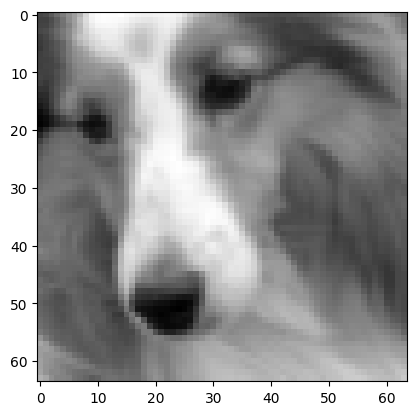

In [9]:
# Load images
# --------------------------------------------------------------------

img_size = 64 # image size

print("Loading image...")
# crop to desired size, set to black and white, normalize
transform = stats.transform_gray_norm(img_size)

# define dataset and dataloader. `image_folder_full` should contain
# a class folder with the images
dataset = torchvision.datasets.ImageFolder(
    image_folder_full, 
    transform=transform
    )

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=10, 
    shuffle=False
    )

# select the image
x, _ = next(iter(dataloader))
x = x[0].unsqueeze(0)
b, c, h, w = x.shape
print("Image shape:", x.shape)

x_plot = x.view(-1, h, h).cpu().numpy()

plt.imshow(x_plot.squeeze(), cmap="gray")


In [37]:
# Simulate measurements for three image intensities
# --------------------------------------------------------------------
# Measurement parameters
# alpha_list = [2, 10, 50] # Poisson law parameter for noisy image acquisitions
alpha = 10 # Poisson law parameter for noisy image acquisitions

und = 4
M = img_size ** 2 // und  # Number of measurements (here, 1/4 of the pixels)

#order_name = 'low_freq'
#order_name = 'naive'
#order_name = 'variance'
order_name = 'random'
# order_name = 'random_variance'
# order_name = 'random_variance_2'
# order_name = 'random_variance_3'


Matrix shape: (64, 64)
Number of elements set to 1: 1024
size of the variance vector (64, 64)


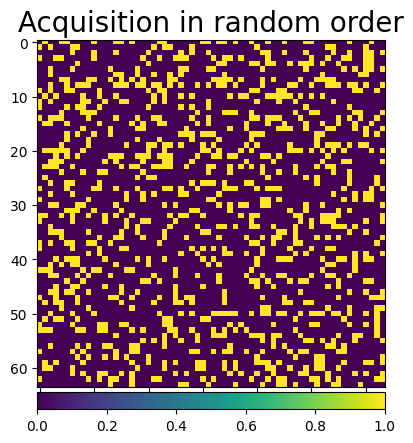

In [38]:
Ord_rec = choose_pattern_order(order_name, img_size)

# Mask of order
mask_basis = np.zeros((h, h))
mask_basis.flat[:M] = 1
print("size of the variance vector",Ord_rec.shape)
mask = sort_by_significance(mask_basis, Ord_rec, axis="flatten")

im = plt.imshow(mask)
plt.title("Acquisition in " + order_name + " order", fontsize=20)
add_colorbar(im, "bottom", size="20%")

In [39]:
# Measurement and noise operators
meas_op = meas.HadamSplit(M, h, torch.from_numpy(Ord_rec))
noise_op = noise.Poisson(meas_op, alpha)
prep_op = prep.SplitPoisson(alpha, meas_op)

 
# Measurement vectors
torch.manual_seed(0)    # for reproducibility
noise_op.alpha = alpha
print ("shape of x", x.shape)
print ("measurment operator" , meas_op.H_pinv.shape)# c'est la pseudo inverse

y = noise_op(x)

shape of x torch.Size([1, 1, 64, 64])
measurment operator torch.Size([4096, 1024])


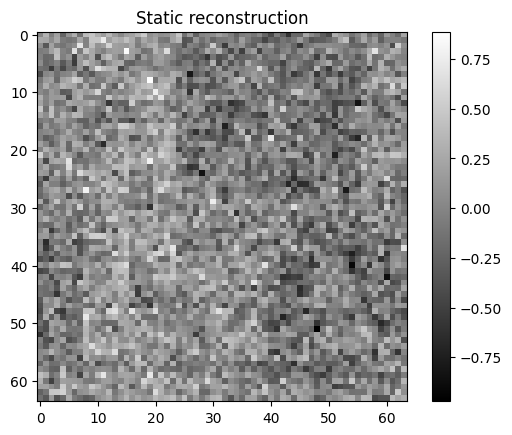

In [40]:
# %% STATIC RECO sans Pinv classe
with torch.no_grad():
    m = prep_op(y)
    f_stat = meas_op.pinv(m)

    plt.imshow(f_stat.view(h, w).cpu().numpy(), cmap='gray')
    plt.title('Static reconstruction')
    plt.colorbar()
    plt.show()



# %%